In [2]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [3]:
def scaling_func(D, L_inf, B, beta):
    return L_inf + B / (D ** beta)

# Loss function: Mean Squared Error
def loss_function(params, D, L_values):
    L_inf, B, beta = params
    L_pred = scaling_func(D, L_inf, B, beta)
    return np.mean((L_pred - L_values) ** 2)


In [27]:

def visualize(L_values, D_values_scaled, L_inf_fit, B_fit, beta_fit, preds=None, tokens_scaling_factor=1e8):
    # Determine the maximum D (in normalized units) from training and prediction data
    max_D_train = np.max(D_values_scaled)
    max_D_preds = max_D_train
    if preds is not None:
        preds = np.array(preds, dtype=object)  # to preserve None entries
        D_preds = preds[:, 0].astype(float)
        D_preds_norm = D_preds / tokens_scaling_factor
        max_D_preds = np.max(D_preds_norm)
    else:
        D_preds_norm = np.array([])  # empty array if preds not provided
    max_D = max(max_D_train, max_D_preds)
    
    # Generate a smooth range for visualization from min D to max_D
    D_fit = np.linspace(np.min(D_values_scaled), max_D, 100)
    D_fit = np.linspace(100,10000,100)
    L_fit = scaling_func(D_fit, L_inf_fit, B_fit, beta_fit)
    
    # Compute predicted loss for training points
    L_pred_train = scaling_func(D_values_scaled, L_inf_fit, B_fit, beta_fit)
    
    # Setup the figure with 2 subplots: left (normal), right (log-log)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # ----- Left Plot: Normal Scale -----
    ax = axs[0]
    ax.scatter(D_values_scaled, L_values, label="Training Data (Observed)", color="red", marker="o", zorder=3)
    ax.plot(D_fit, L_fit, label=f"Fitted Curve\n$L(D)= {L_inf_fit:.4f} + {B_fit:.4f} / D^{{{beta_fit:.4f}}}$", color="blue", linewidth=2)
    ax.scatter(D_values_scaled, L_pred_train, label="Training Data (Fitted)", color="green", marker="x", zorder=3)
    
    if preds is not None:
        # Process prediction data
        # D_preds_norm is already computed; now extract observed losses, if any.
        # Create a boolean mask: True if the ground truth is not None.
        observed_mask = np.array([p is not None for p in preds[:, 1]])
        
        # Compute projected loss from the curve for new predictions
        L_fitted_preds = scaling_func(D_preds_norm, L_inf_fit, B_fit, beta_fit)
        
        # Plot projected values (all new predictions)
        ax.scatter(D_preds_norm, L_fitted_preds, label="New Data (Projected)", color="black", marker="*", s=120, zorder=3)
        
        # If observed ground truth exists for any, plot them
        if np.any(observed_mask):
            L_preds_observed = np.array([float(p) for p in preds[:, 1] if p is not None])
            D_preds_norm_obs = D_preds_norm[observed_mask]
            ax.scatter(D_preds_norm_obs, L_preds_observed, label="New Data (Observed)", color="purple", marker="^", s=100, zorder=3)
        
        # Annotate all new prediction points with their projected value
        for i in range(len(D_preds_norm)):
            ax.annotate(f"Proj: {L_fitted_preds[i]:.4f}", 
                        (D_preds_norm[i], L_fitted_preds[i]), 
                        textcoords="offset points", xytext=(5, -10), ha="left", fontsize=10, color="black")
    
    ax.set_xlabel(f"Training Tokens (×{tokens_scaling_factor:.0e})")
    ax.set_ylabel("Loss")
    ax.set_title("Scaling Law Fit (Normal Scale)")
    ax.legend()
    ax.grid(True)
    
    # ----- Right Plot: Log-Log Scale -----
    ax = axs[1]
    # Plot the extended fitted curve
    ax.loglog(D_fit, L_fit, 'b-', label="Fitted Curve", linewidth=2)
    # Plot training data points
    ax.loglog(D_values_scaled, L_values, 'ro', label="Training Data (Observed)")
    ax.loglog(D_values_scaled, L_pred_train, 'gx', label="Training Data (Fitted)")
    
    if preds is not None:
        ax.loglog(D_preds_norm, L_fitted_preds, '*', label="New Data (Projected)", color="black", markersize=10)
        if np.any(observed_mask):
            ax.loglog(D_preds_norm[observed_mask], np.array([float(p) for p in preds[:, 1] if p is not None]), 
                      'p', label="New Data (Observed)", color="purple", markersize=8)
    
    ax.set_xlabel(f"Training Tokens (log scale, ×{tokens_scaling_factor:.0e})")
    ax.set_ylabel("Loss (log scale)")
    ax.set_title("Scaling Law Fit (Log-Log Scale)")
    ax.legend()
    ax.grid(True, which="both", linestyle="--")
    
    plt.tight_layout()
    plt.show()
    
    # Print fitted parameters
    print(f"Optimized L_inf: {L_inf_fit:.4f}")
    print(f"Optimized B: {B_fit:.4f}")
    print(f"Optimized beta: {beta_fit:.4f}")
    
    if preds is not None:
        print("\nNew Data Predictions:")
        for i in range(len(D_preds_norm)):
            if observed_mask[i]:
                print(f"Tokens: {D_preds_norm[i]:.2f}{tokens_scaling_factor}, Observed Loss: {float(preds[i,1]):.4f}, Projected Loss: {L_fitted_preds[i]:.4f}")
            else:
                print(f"Tokens: {D_preds_norm[i]:.2f}{tokens_scaling_factor}, Projected Loss: {L_fitted_preds[i]:.4f}")




In [28]:
tokens_scaling_factor = 1e7
D_values = np.array([1_101_004_800, 2_202_009_600, 3_355_433_200, 4_404_019_200, 5_583_443_200])
D_values_scaled = D_values / tokens_scaling_factor
L_values = np.array([1.1143, 1.0585, 1.0474, 1.0206, 1.0139])  
preds = np.array([(7_445_299_200, 1.0191), (8_375_500_800, 1.0112), (55_836_672_000, 0.9540)])

L_inf: 0.8984763580651995, B: 1.300871129652191, beta: 0.382850388037544


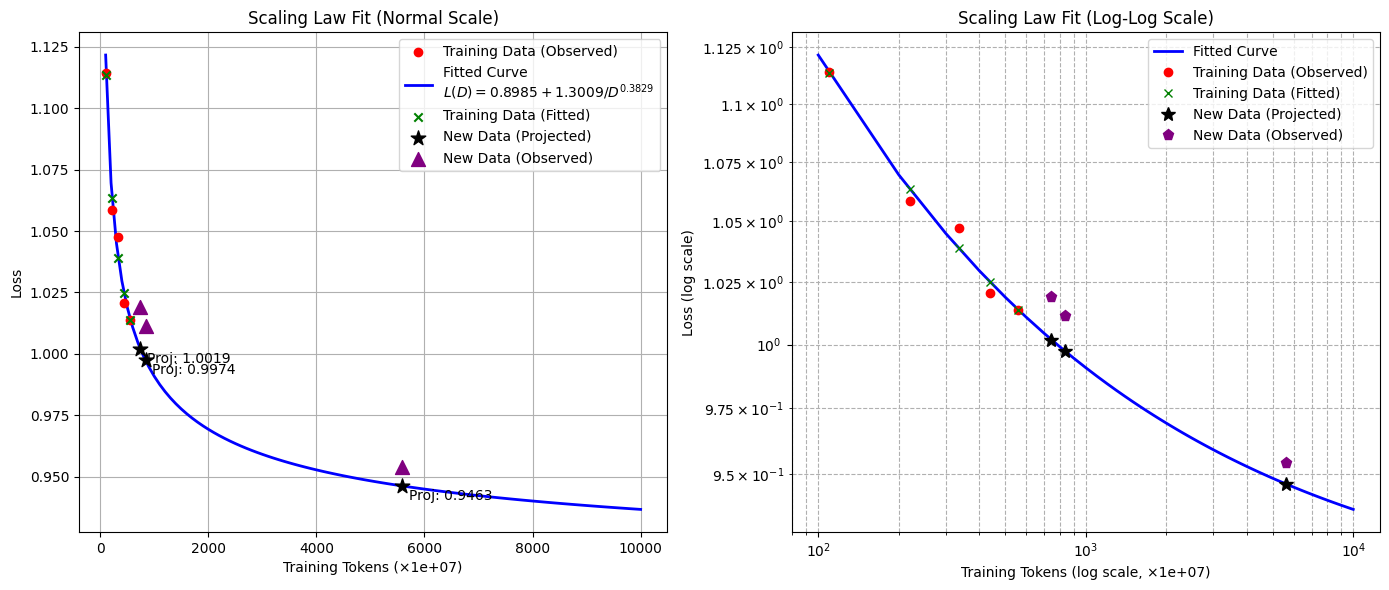

Optimized L_inf: 0.8985
Optimized B: 1.3009
Optimized beta: 0.3829

New Data Predictions:
Tokens: 744.5310000000.0, Observed Loss: 1.0191, Projected Loss: 1.0019
Tokens: 837.5510000000.0, Observed Loss: 1.0112, Projected Loss: 0.9974
Tokens: 5583.6710000000.0, Observed Loss: 0.9540, Projected Loss: 0.9463


In [29]:
popt, pcov = curve_fit(scaling_func, D_values_scaled, L_values, p0=[min(L_values), 5, 0.3])
L_inf_fit, B_fit, beta_fit = popt
print(f"L_inf: {L_inf_fit}, B: {B_fit}, beta: {beta_fit}")

visualize(L_values, D_values_scaled, L_inf_fit, B_fit, beta_fit, preds, tokens_scaling_factor=tokens_scaling_factor)

L_inf: 0.9773064441773317, B: 5.001158123401194, beta: 0.7625588965785991


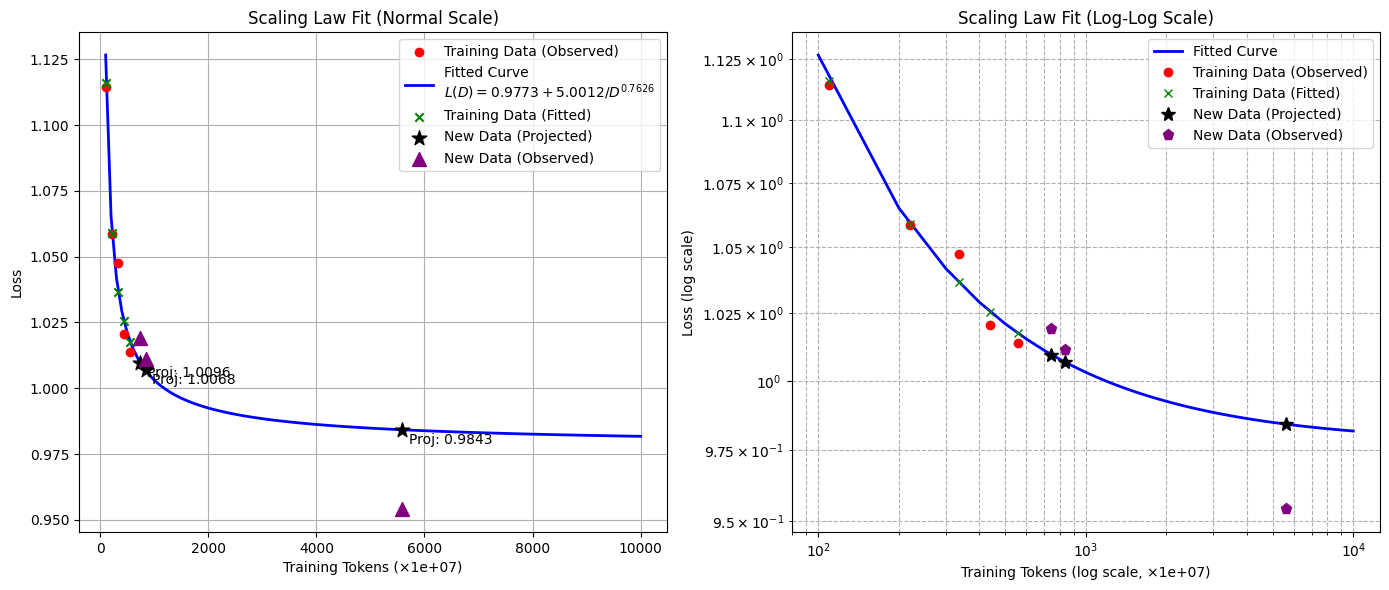

Optimized L_inf: 0.9773
Optimized B: 5.0012
Optimized beta: 0.7626

New Data Predictions:
Tokens: 744.5310000000.0, Observed Loss: 1.0191, Projected Loss: 1.0096
Tokens: 837.5510000000.0, Observed Loss: 1.0112, Projected Loss: 1.0068
Tokens: 5583.6710000000.0, Observed Loss: 0.9540, Projected Loss: 0.9843


In [30]:

# Initial parameter guesses (L_inf, B, beta)
initial_guess = [min(L_values), 5, 0.3]

# Run L-BFGS-B optimization
result = minimize(loss_function, initial_guess, args=(D_values_scaled, L_values), method='L-BFGS-B')

# Extract optimized parameters
L_inf_fit, B_fit, beta_fit = result.x
print(f"L_inf: {L_inf_fit}, B: {B_fit}, beta: {beta_fit}")


visualize(L_values, D_values_scaled, L_inf_fit, B_fit, beta_fit, preds, tokens_scaling_factor=tokens_scaling_factor)


In [ ]:
D_values = np.array([1_101_004_800, 2_202_009_600, 3_355_433_200, 4_404_019_200, 5_583_443_200])
L_values = np.array([1.0505, 0.999, 0.9844, 0.9597, 0.9527])  
D_values_scaled = D_values / 1e9

preds = np.array([(7.445e9, 0.9588), (11.167e9, 0.9306), (5583.667e9,None)])